In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt


from filters.kalman_filter import SimplestKalmanFilter1D, LinearKalmanFilterND
from simulations.stochastic_models import StochasticModels

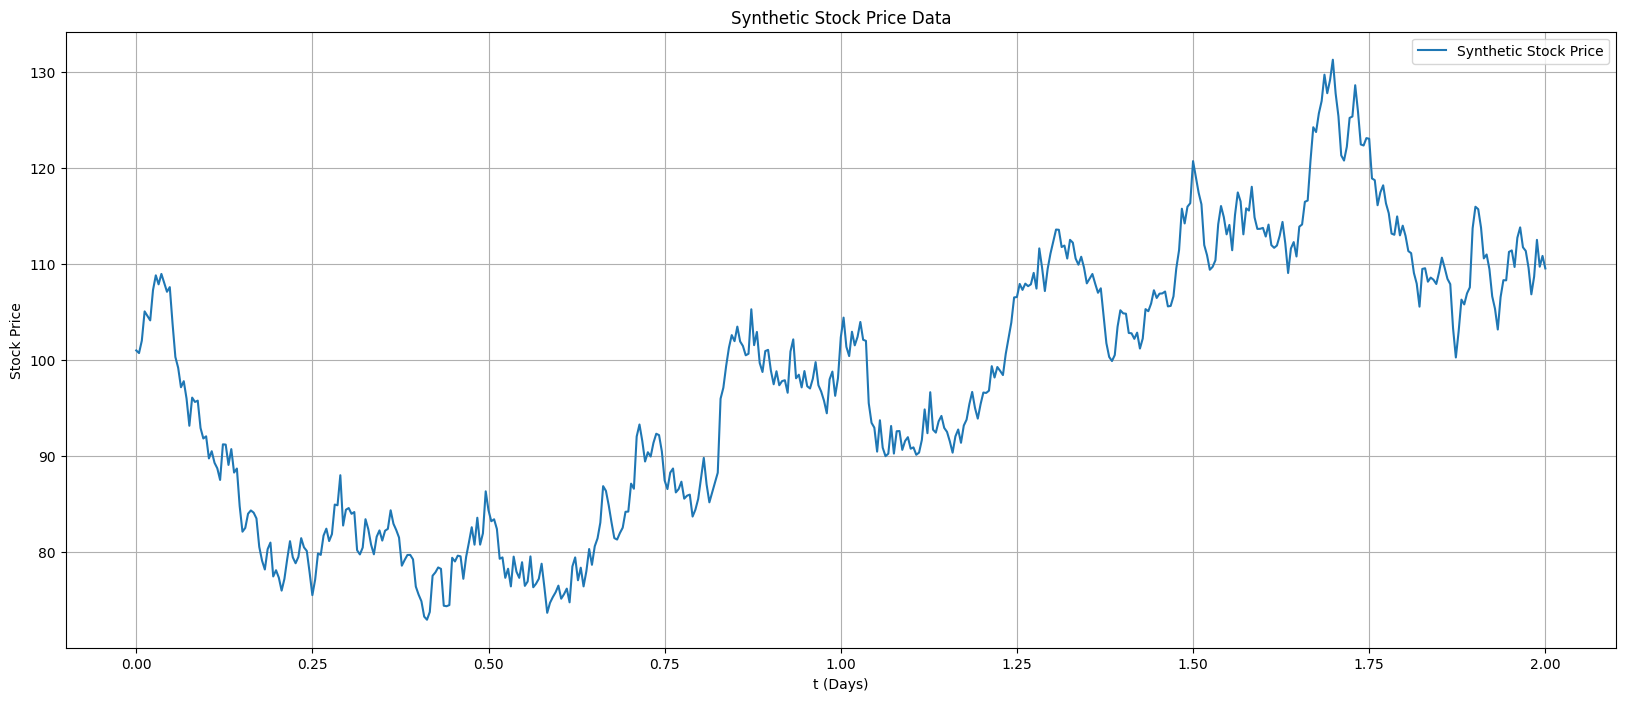

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Number of days for our synthetic stock data
num_days = 250


t, prices = StochasticModels.simulate_random_walk_process(2, 100)

# Plot the synthetic stock price data
plt.figure(figsize=(20, 8))
plt.plot(t, prices, label="Synthetic Stock Price")
plt.title("Synthetic Stock Price Data")
plt.xlabel("t (Days)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Kalman & estimation

The SSM here of the Kalman filter is given by:

$$
\begin{cases}
    x_t = Ax_{t-1} + w_t \\
    y_t = Cx_t + v_t
\end{cases}
$$

Where :

- $x_t$ is the state vector of dimension $1$ at time $t$ is contains the price of the asset
- $y_t$ is the observation vector of dimension $1$ at time $t$ is contains the price of the asset since we observe the price of the asset and there are not unit conversion.
- $A$ and $C$ are the matrices of the model here $A = 1$ and $C = 1$.

Then :

$$
\begin{cases}
    x_t = x_{t-1} + w_t \\
    y_t = x_t + v_t
\end{cases}
$$


## Simple model


In [3]:
# Parameters for our Kalman filter
Q = 1  # Process noise variance (assumption)
R = 4  # Measurement noise variance (based on our synthetic data generation)

# Create and run the Kalman filter
kf = SimplestKalmanFilter1D(Q, R)
price_hat, _ = kf.fit_predict(prices, verbose=False)

Kalman Filter Progress: 100%|██████████| 504/504 [00:00<00:00, 508278.24it/s]


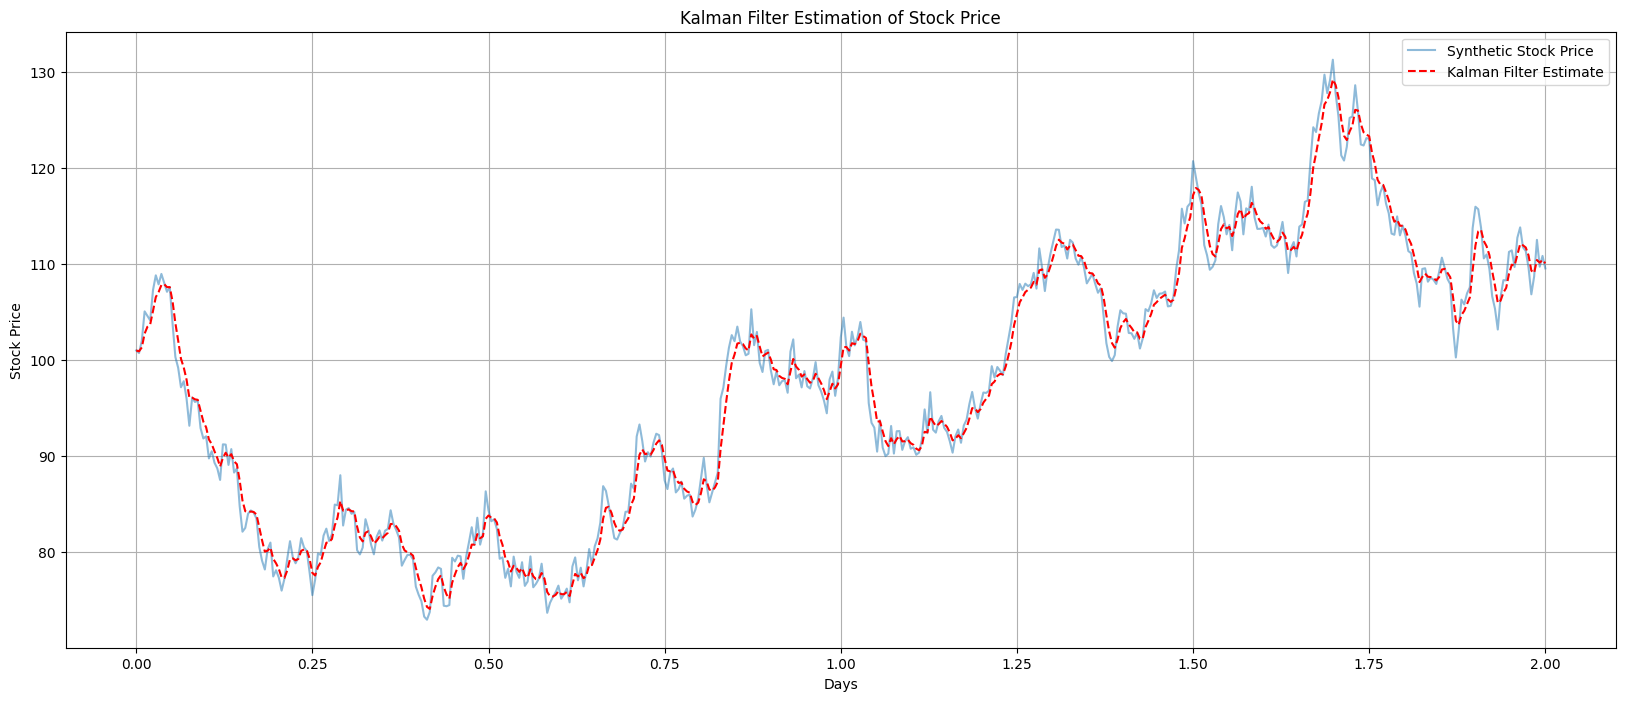

In [4]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(t, prices, label="Synthetic Stock Price", alpha=0.5)
plt.plot(t, price_hat, label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

## Use the simplest model but with the DSSM from article

In [ ]:
# from : https://medium.com/@akjha22/kalman-filters-for-stock-price-signal-generation-f64015da637d
class SimplestKalmanFilter1D:
    def __init__(self, Q: Union[np.float64, int], R: Union[np.float64, int]):
        # Process noise variance
        self.Q = Q
        # Measurement noise variance
        self.R = R

    def __before_estimation_init(self, z: npt.NDArray[np.float64]):
        # Number of epochs
        self.num_days = z.shape[0]
        # Initial state estimate
        self.P_hat = np.zeros(self.num_days)
        # Initial state estimate error variance
        self.P_var = np.zeros(self.num_days)

    def fit_predict(
        self, z: npt.NDArray[np.float64], verbose: bool = False
    ) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
        self.__before_estimation_init(z)

        # Initial estimate of state
        self.P_hat[0] = z[0]

        # Initial estimate of state variance
        self.P_var[0] = 1.0

        for t in tqdm(
            range(1, self.num_days),
            desc="Kalman Filter Progress",
            leave=True,
            total=self.num_days - 1,
        ):
            # ******* Prediction Step *******

            # Predicted state estimate
            # P_hat_minus = self.P_hat[t - 1]
            P_hat_minus = self.P_hat[t - 1]
            # Predicted error variance
            P_var_minus = self.P_var[t - 1] + self.Q

            # ******* Update Step *******

            # Kalman gain
            Kt = P_var_minus / (P_var_minus + self.R)

            if verbose is True:
                print(f"Kalman Gain at epoch {t} : {Kt:.4f}")

            # Updated state estimate
            self.P_hat[t] = P_hat_minus + Kt * (z[t] - P_hat_minus)
            # Updated estimate of state variance
            self.P_var[t] = (1 - Kt) * P_var_minus

        return self.P_hat, self.P_var

## N-dimension kalman filter


In [ ]:
# Kalman Filter Initialization
F = np.array([[1, 1], [0, 1]])  # State transition matrix
B = np.array([[0], [0]])  # No control input
u = np.array([[0]])  # No control input
H = np.array([[1, 0]])  # Measurement function
Q = np.array([[1, 0], [0, 3]])  # Process noise covariance
R = np.array([[2**2]])  # Measurement noise covariance
x0 = np.array([[0], [0]])  # Initial state estimate
P0 = np.array([[1, 0], [0, 1]])  # Initial estimate covariance

kf = KalmanFilterND(F, B, u, H, Q, R, x0, P0)



# Allocate space for estimated positions and velocities
estimated_positions = np.zeros(t.shape[0])
estimated_velocities = np.zeros(t.shape[0])

# Kalman Filter Loop
for i in range(t.shape[0]):
    # Predict
    kf.predict()
    
    # Update
    measurement = np.array([[prices[i]]])
    kf.update(measurement)
    
    # Store the filtered position and velocity
    estimated_positions[t] = kf.x[0]
    estimated_velocities[t] = kf.x[1]

# Plot the true positions, noisy measurements, and the Kalman filter estimates
plt.figure(figsize=(10, 6))
plt.plot(t, prices, label='True prices', color='green')
plt.plot(t, estimated_positions, label='Kalman Filter Estimate', color='blue')
